In [2]:
!gpustat

hyperion  Fri Mar 22 17:14:34 2019
[0] TITAN X (Pascal) | 66'C,  47 % | 11725 / 12196 MB | jdram(11715M)
[1] TITAN X (Pascal) | 84'C,  61 % | 11725 / 12196 MB | jdram(11715M)
[2] TITAN X (Pascal) | 83'C,  61 % | 11725 / 12196 MB | jdram(11715M)
[3] TITAN X (Pascal) | 31'C,   0 % |     0 / 12196 MB |
[4] TITAN X (Pascal) | 76'C,  41 % | 11725 / 12196 MB | jdram(11715M)
[5] TITAN X (Pascal) | 25'C,   0 % |     0 / 12196 MB |
[6] TITAN X (Pascal) | 31'C,   0 % |   571 / 12196 MB | maghoi(561M)
[7] TITAN X (Pascal) | 25'C,   0 % |     0 / 12196 MB |


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [9]:
import numpy as np
import pandas as pd
np.random.seed(12345)
import matplotlib.pyplot as plt
%matplotlib inline

from fastai.basic_data import *
from fastai.basic_train import *
from fastai.data_block import *
from fastai.metrics import *
from fastai.train import *
from fastai.utils import *
from fastai.core import *
from fastai.gen_doc import *

import torch
import torch.nn as nn
import torch.utils.data as tdatautils

## 1. Create toy data set & dataloader objects

### 1.a Create double-XOR data set as a toy example

Setting up XOR data <b>not</b> because it is interesting, but just to demonstrate what you do with NUMPY input data passed into the Learner() pipeline

In [11]:
def data_generator(data_size=1024):
    while 1:
        x1 = np.random.randint(0, 2, size=data_size)
        x2 = np.random.randint(0, 2, size=data_size)
        x3 = np.random.randint(0, 2, size=data_size)
        x4 = np.random.randint(0, 2, size=data_size)
        x = np.concatenate((x1[:, None],
                            x2[:, None],
                            x3[:, None],
                            x4[:,None]), axis=1).astype(float)
        #encode y as one-hot so we can easily scale to multi-class problems.
        y0 = (x1 != x2).astype(float)
        y1 = (x3 != x4).astype(float)
        y = np.concatenate((y0[:,None],y1[:,None]),axis=1).astype(float)
        y = y.sum(axis=1) #creates classes 0,1,2
        yield x, y

In [12]:
X,y = next(data_generator(data_size=1024))
X_val,y_val = next(data_generator(data_size=512))
X_test,y_test = next(data_generator(data_size=100))
print(X)
print(y)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 1. 1. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]
[1. 1. 0. 1. ... 0. 1. 1. 1.]


### 1.b Map the data to float/int as appropriate

Classification requires that targets are type INT

In [13]:
def to_torch_data(x,np_type,tch_type):
    return torch.from_numpy(x.astype(np_type)).to(tch_type)

X,X_val,X_test = map(lambda x: to_torch_data(x,float,torch.float32),(X,X_val,X_test))
y,y_val,y_test = map(lambda x: to_torch_data(x,int,torch.int64),(y,y_val,y_test))

In [14]:
train_ds = tdatautils.TensorDataset(X,y)
valid_ds = tdatautils.TensorDataset(X_val,y_val)
test_ds  = tdatautils.TensorDataset(X_test,y_test)

### 1.c Create fast.ai objects from Numpy data

In [27]:
batch_size = 32
my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)

Example of what a single batch looks like.  As expected from the data definition

In [28]:
my_data_bunch.one_batch()

(tensor([[0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 1., 1., 0.],
         [0., 0., 0., 1.],
         [1., 1., 0., 0.],
         [1., 0., 1., 0.],
         [0., 0., 1., 1.],
         [1., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 1., 0., 1.],
         [0., 0., 1., 1.],
         [1., 0., 0., 1.],
         [0., 1., 1., 0.],
         [1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [1., 1., 1., 1.],
         [0., 0., 1., 1.],
         [0., 1., 1., 0.],
         [1., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 1., 1., 1.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 1.],
         [1., 0., 1., 0.]]),
 tensor([1, 1, 1, 1, 0, 2, 0, 2, 1, 1, 1, 2, 0, 2, 2, 0, 0, 1, 0, 0, 1, 1, 0, 0,
         2, 2, 1, 1, 1, 1, 0, 2]))

## 2. Define Loss & Model

In [45]:
criterion = nn.NLLLoss() # NLL + Log_softmax layer = multi-class Cross-entropy

### 2.a nn.Sequential way to define a model

In [46]:
def count_model_params(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [47]:
H = 10
net = nn.Sequential(
    nn.Linear(4, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, 3),
    nn.LogSoftmax(dim=1)
)#.cuda()
print(net)
print( 'trainable params: {}'.format(count_model_params(net)) )

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=3, bias=True)
  (5): LogSoftmax()
)
trainable params: 193


### 2.b Class definition of model

In [48]:
class Net(nn.Module):
    def __init__(self, input_size=21, hidden_size=10, num_classes=10):
        super(Net, self).__init__()
        self.fc_0 = nn.Linear(input_size, hidden_size) 
        self.relu_0 = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size,hidden_size)        
        self.relu_1 = nn.ReLU()
        self.last = nn.Linear(hidden_size,num_classes)
        self.log_softmax_layer = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.relu_0(self.fc_0(x))
        out = self.relu_1(self.fc_1(out))
        out = self.log_softmax_layer(self.last(out))
        
        return out
    
#create instance of model
net = Net(input_size=4,hidden_size=10,num_classes=3).cuda()
print(net)  
print( 'trainable params: {}'.format(count_model_params(net)) )

Net(
  (fc_0): Linear(in_features=4, out_features=10, bias=True)
  (relu_0): ReLU()
  (fc_1): Linear(in_features=10, out_features=10, bias=True)
  (relu_1): ReLU()
  (last): Linear(in_features=10, out_features=3, bias=True)
  (log_softmax_layer): LogSoftmax()
)
trainable params: 193


## 3. Build Learner

In [49]:
my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion)

#### From here we can use the learner just like any other Fast.ai learner

In [34]:
my_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


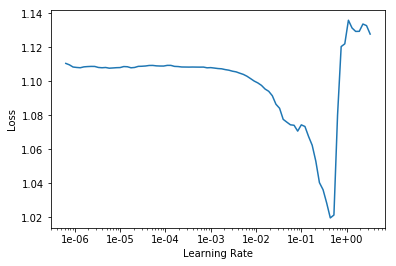

In [35]:
my_learner.recorder.plot()

In [50]:
my_learner.fit_one_cycle(1,1e-1)

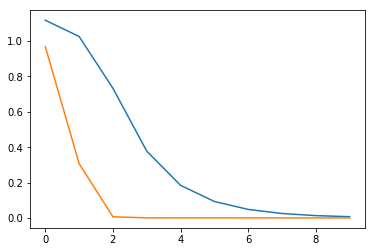

In [37]:
plt.plot(my_learner.recorder.losses[::batch_size]) #losses for each batch.  Take at end of epoch only
plt.plot(my_learner.recorder.val_losses)

In [41]:
my_learner.get_preds()[0][0:10]

tensor([[9.9863e-01, 1.3686e-03, 1.1910e-12],
        [9.9863e-01, 1.3686e-03, 1.1910e-12],
        [6.6310e-04, 9.9926e-01, 7.9572e-05],
        [6.8382e-05, 9.9972e-01, 2.0862e-04],
        [2.6772e-11, 9.3723e-04, 9.9906e-01],
        [9.9987e-01, 1.3041e-04, 2.0266e-09],
        [2.3160e-06, 9.9995e-01, 4.7040e-05],
        [2.3160e-06, 9.9995e-01, 4.7040e-05],
        [6.1612e-05, 9.9993e-01, 3.9783e-06],
        [2.0437e-15, 3.9302e-04, 9.9961e-01]])

In [42]:
my_learner.get_preds()[1][0:10]

tensor([0, 0, 1, 1, 2, 0, 1, 1, 1, 2])

In [44]:
y_val

tensor([0, 0, 1, 1, 2, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 0, 0, 1, 2, 1, 1, 0, 1, 1,
        1, 1, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 2, 2, 1, 0, 2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 0,
        0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 0, 0, 2, 1,
        1, 0, 2, 1, 0, 0, 1, 2, 2, 2, 2, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 2, 1, 1,
        0, 0, 1, 1, 1, 2, 0, 1, 2, 0, 0, 2, 1, 0, 1, 2, 2, 2, 0, 2, 1, 0, 0, 1,
        1, 1, 2, 2, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 0,
        0, 0, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1,
        1, 2, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2, 2, 1, 2, 0, 1, 0, 1, 1,
        1, 1, 0, 2, 1, 0, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 2, 2, 1,
        0, 1, 1, 1, 2, 2, 0, 1, 0, 2, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2,
        1, 2, 2, 1, 1, 1, 0, 0, 0, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1,
        0, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1,